### Importing Required Libraries for data loading, model building, evaluation, and visualization

In [38]:
import h5py
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchaudio.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

### Loading HDF5 files and splitting the data for training

In [18]:
# Load and label spectrogram data for each species
with h5py.File(file_path, 'r') as f:
    keys = list(f.keys())
    X_list, y_list = [], []
    for idx, species in enumerate(keys):
        data = np.transpose(f[species][:], (2, 0, 1))  # (samples, 128, 517)
        labels = np.full(len(data), idx)
        X_list.append(data)
        y_list.append(labels)

#Combine all species into a single dataset of X(features) and y(target)
X = np.concatenate(X_list)
y = np.concatenate(y_list)

In [20]:
X.shape

(1981, 128, 517)

In [21]:
y.shape

(1981,)

In [22]:
perm = np.random.permutation(len(X))
X = X[perm]
y = y[perm]
X_tensor = torch.tensor(X[:, np.newaxis, :, :], dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Dataset split
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

In [23]:
X_tensor.shape

torch.Size([1981, 1, 128, 517])

In [24]:
#Conv. layer followed by batch normalization. Max pool of (2,2) followed by Adapative Avg. pool of (4,4) 
class BirdMultiClassCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d((4, 4))
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(32 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(np.unique(y))
model = BirdMultiClassCNN(num_classes=num_classes).to(device)

#Weighted classes
class_counts = np.bincount(y)
weights = [sum(class_counts) / c for c in class_counts]
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

#Cross Entropy and Adam optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [26]:
train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []
best_val_loss = float('inf')
patience, trigger_times = 5, 0
best_model_state = None

for epoch in range(50):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct += (preds.argmax(dim=1) == yb).sum().item()
        total += yb.size(0)

    train_loss_hist.append(running_loss / len(train_loader))
    train_acc_hist.append(correct / total)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            val_loss += criterion(preds, yb).item()
            val_correct += (preds.argmax(dim=1) == yb).sum().item()
            val_total += yb.size(0)

    val_loss_epoch = val_loss / len(val_loader)
    val_acc_epoch = val_correct / val_total
    val_loss_hist.append(val_loss_epoch)
    val_acc_hist.append(val_acc_epoch)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss_hist[-1]:.4f} | Val Loss: {val_loss_epoch:.4f} "
          f"| Train Acc: {train_acc_hist[-1]:.4f} | Val Acc: {val_acc_epoch:.4f}")

    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        best_model_state = model.state_dict()
        trigger_times = 0
    else:
        trigger_times += 1
        print(f"→ No improvement. Early stopping trigger {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("→ Early stopping!")
            break

# Restore best model
if best_model_state:
    model.load_state_dict(best_model_state)

# Evaluate on test set
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb).argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())

# Report and confusion matrix
test_accuracy = accuracy_score(all_labels, all_preds)
classification_rep = classification_report(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

(test_accuracy, classification_rep, conf_matrix)

Epoch 01 | Train Loss: 2.4980 | Val Loss: 2.4541 | Train Acc: 0.0909 | Val Acc: 0.1010
Epoch 02 | Train Loss: 2.4521 | Val Loss: 2.4594 | Train Acc: 0.1061 | Val Acc: 0.0842
→ No improvement. Early stopping trigger 1/5
Epoch 03 | Train Loss: 2.4468 | Val Loss: 2.4461 | Train Acc: 0.1190 | Val Acc: 0.1582
Epoch 04 | Train Loss: 2.4153 | Val Loss: 2.4826 | Train Acc: 0.1356 | Val Acc: 0.1111
→ No improvement. Early stopping trigger 1/5
Epoch 05 | Train Loss: 2.4086 | Val Loss: 2.4189 | Train Acc: 0.1364 | Val Acc: 0.1178
Epoch 06 | Train Loss: 2.3628 | Val Loss: 2.4132 | Train Acc: 0.1263 | Val Acc: 0.1077
Epoch 07 | Train Loss: 2.3437 | Val Loss: 2.3837 | Train Acc: 0.1392 | Val Acc: 0.1145
Epoch 08 | Train Loss: 2.3401 | Val Loss: 2.3861 | Train Acc: 0.1421 | Val Acc: 0.1549
→ No improvement. Early stopping trigger 1/5
Epoch 09 | Train Loss: 2.3195 | Val Loss: 2.3446 | Train Acc: 0.1472 | Val Acc: 0.1380
Epoch 10 | Train Loss: 2.2965 | Val Loss: 2.3579 | Train Acc: 0.1494 | Val Acc: 0.

C:\Users\Ankit P Bisleri\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Ankit P Bisleri\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Ankit P Bisleri\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

(0.17114093959731544,
 '              precision    recall  f1-score   support\n\n           0       0.31      0.62      0.42         8\n           1       0.13      0.11      0.12        27\n           2       0.08      0.09      0.09        22\n           3       0.00      0.00      0.00         6\n           4       0.16      0.48      0.24        21\n           5       0.09      0.33      0.14        12\n           6       0.65      0.14      0.22        81\n           7       0.00      0.00      0.00         8\n           8       0.09      0.16      0.12        19\n           9       0.50      0.10      0.16        51\n          10       0.27      0.32      0.29        25\n          11       0.00      0.00      0.00        18\n\n    accuracy                           0.17       298\n   macro avg       0.19      0.20      0.15       298\nweighted avg       0.33      0.17      0.17       298\n',
 array([[ 5,  0,  0,  0,  1,  0,  1,  0,  1,  0,  0,  0],
        [ 0,  3,  2,  3,  4, 11

In [29]:
print(BirdMultiClassCNN(num_classes=12))

BirdMultiClassCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_pool): AdaptiveAvgPool2d(output_size=(4, 4))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=512, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=12, bias=True)
)


#### The above gives us an accuracy of 17.11% giving us a lot of room to improve

In [49]:
class AdvancedBirdCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        #Each Conv. block has Conv. layer, Batch normalization, ReLu and Max Pooling
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.global_pool = nn.AdaptiveAvgPool2d((4, 4)) # Reduces spatial dimension
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(128 * 4 * 4, 128) #Fully connected layer
        self.fc2 = nn.Linear(128, num_classes) #Output Layer

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        return self.fc2(x)

#Focal loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

#augmentation (on-the-fly)
class SpectrogramDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32).unsqueeze(0)  # (1, 128, 517)
        x = (x - x.mean()) / (x.std() + 1e-6)
        y = self.y[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

#Data augmentation using SpecAugment-inspired masking
augment = torch.nn.Sequential(
    T.FrequencyMasking(freq_mask_param=15),
    T.TimeMasking(time_mask_param=25)
)

#Balance dataset
def get_sampler(y):
    class_sample_counts = np.bincount(y)
    weights = 1. / class_sample_counts[y]
    sampler = WeightedRandomSampler(weights, len(weights), replacement=True)
    return sampler

In [52]:
# Initialize model and training settings
model = AdvancedBirdCNN(num_classes=num_classes).to(device)
class_counts = np.bincount(y)
alpha = torch.tensor([1.0 / c for c in class_counts], dtype=torch.float32)
alpha = (alpha / alpha.sum()).to(device)
criterion = FocalLoss(alpha=alpha, gamma=2.0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [35]:
train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []
best_val_loss = float('inf')
patience, trigger_times = 5, 0
best_model_state = None

for epoch in range(50):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct += (preds.argmax(dim=1) == yb).sum().item()
        total += yb.size(0)

    train_loss_hist.append(running_loss / len(train_loader))
    train_acc_hist.append(correct / total)

    
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            val_loss += criterion(preds, yb).item()
            val_correct += (preds.argmax(dim=1) == yb).sum().item()
            val_total += yb.size(0)

    val_loss_epoch = val_loss / len(val_loader)
    val_acc_epoch = val_correct / val_total
    val_loss_hist.append(val_loss_epoch)
    val_acc_hist.append(val_acc_epoch)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss_hist[-1]:.4f} | Val Loss: {val_loss_epoch:.4f} "
          f"| Train Acc: {train_acc_hist[-1]:.4f} | Val Acc: {val_acc_epoch:.4f}")

    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        best_model_state = model.state_dict()
        trigger_times = 0
    else:
        trigger_times += 1
        print(f"→ No improvement. Early stopping trigger {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("→ Early stopping!")
            break

if best_model_state:
    model.load_state_dict(best_model_state)

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb).argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())


test_accuracy = accuracy_score(all_labels, all_preds)
classification_rep = classification_report(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

(test_accuracy, classification_rep, conf_matrix)

Epoch 01 | Train Loss: 0.0060 | Val Loss: 0.0039 | Train Acc: 0.0332 | Val Acc: 0.0303
Epoch 02 | Train Loss: 0.0038 | Val Loss: 0.0038 | Train Acc: 0.0260 | Val Acc: 0.0303
Epoch 03 | Train Loss: 0.0036 | Val Loss: 0.0039 | Train Acc: 0.0260 | Val Acc: 0.0236
→ No improvement. Early stopping trigger 1/5
Epoch 04 | Train Loss: 0.0036 | Val Loss: 0.0040 | Train Acc: 0.0332 | Val Acc: 0.0168
→ No improvement. Early stopping trigger 2/5
Epoch 05 | Train Loss: 0.0033 | Val Loss: 0.0038 | Train Acc: 0.0361 | Val Acc: 0.0337
→ No improvement. Early stopping trigger 3/5
Epoch 06 | Train Loss: 0.0033 | Val Loss: 0.0041 | Train Acc: 0.0361 | Val Acc: 0.0303
→ No improvement. Early stopping trigger 4/5
Epoch 07 | Train Loss: 0.0031 | Val Loss: 0.0049 | Train Acc: 0.0440 | Val Acc: 0.0606
→ No improvement. Early stopping trigger 5/5
→ Early stopping!


C:\Users\Ankit P Bisleri\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Ankit P Bisleri\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Ankit P Bisleri\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

(0.09060402684563758,
 '              precision    recall  f1-score   support\n\n           0       0.05      0.62      0.10         8\n           1       0.00      0.00      0.00        27\n           2       0.12      0.14      0.12        22\n           3       0.02      0.33      0.04         6\n           4       0.00      0.00      0.00        21\n           5       0.25      0.25      0.25        12\n           6       0.00      0.00      0.00        81\n           7       0.00      0.00      0.00         8\n           8       0.00      0.00      0.00        19\n           9       0.00      0.00      0.00        51\n          10       0.22      0.56      0.31        25\n          11       0.00      0.00      0.00        18\n\n    accuracy                           0.09       298\n   macro avg       0.05      0.16      0.07       298\nweighted avg       0.04      0.09      0.05       298\n',
 array([[ 5,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 5,  0,  3, 10,  0,  4

#### Augmenting the data, changing the Arch and adding Focal Loss(addresses weight imbalnce) resulted in lower accuracy(Model is unstable)
#### Lets try downsample and see if there is actually class imbalnce 

In [36]:
# Downsampling function to balance all classes equally
def downsample_classes(X, y):
    class_indices = defaultdict(list)
    for i, label in enumerate(y):
        class_indices[label].append(i)

    min_class_count = min(len(indices) for indices in class_indices.values())

    balanced_indices = []
    for label, indices in class_indices.items():
        balanced_indices.extend(np.random.choice(indices, min_class_count, replace=False))

    np.random.shuffle(balanced_indices)
    return X[balanced_indices], y[balanced_indices]

In [39]:
X_bal, y_bal = downsample_classes(X, y)
dataset = SpectrogramDataset(X_bal, y_bal, transform=augment)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [40]:
# Initialize model and training settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(np.unique(y_bal))
model = AdvancedBirdCNN(num_classes=num_classes).to(device)
criterion = FocalLoss(alpha=None, gamma=2.0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [44]:
#Training loop
train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []
best_val_loss = float('inf')
patience = 5
trigger_times = 0
best_model_state = None

for epoch in range(50):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device).long()
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (outputs.argmax(dim=1) == yb).sum().item()
        total += yb.size(0)

    train_loss_hist.append(running_loss / len(train_loader))
    train_acc_hist.append(correct / total)

   
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            val_loss += criterion(outputs, yb).item()
            val_correct += (outputs.argmax(dim=1) == yb).sum().item()
            val_total += yb.size(0)

    val_loss_epoch = val_loss / len(val_loader)
    val_acc_epoch = val_correct / val_total
    val_loss_hist.append(val_loss_epoch)
    val_acc_hist.append(val_acc_epoch)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss_hist[-1]:.4f} | "
          f"Val Loss: {val_loss_epoch:.4f} | Train Acc: {train_acc_hist[-1]:.4f} | "
          f"Val Acc: {val_acc_epoch:.4f}")

    # Early stopping
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        best_model_state = model.state_dict()
        trigger_times = 0
    else:
        trigger_times += 1
        print(f"→ No improvement. Early stopping trigger {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("→ Early stopping!")
            break

if best_model_state:
    model.load_state_dict(best_model_state)

Epoch 01 | Train Loss: 2.2457 | Val Loss: 2.1898 | Train Acc: 0.0721 | Val Acc: 0.0673
Epoch 02 | Train Loss: 2.1021 | Val Loss: 2.0900 | Train Acc: 0.1194 | Val Acc: 0.0909
Epoch 03 | Train Loss: 2.0678 | Val Loss: 2.0414 | Train Acc: 0.1149 | Val Acc: 0.1582
Epoch 04 | Train Loss: 2.0398 | Val Loss: 2.0375 | Train Acc: 0.1239 | Val Acc: 0.1010
Epoch 05 | Train Loss: 2.0639 | Val Loss: 2.0652 | Train Acc: 0.1081 | Val Acc: 0.1145
→ No improvement. Early stopping trigger 1/5
Epoch 06 | Train Loss: 2.0524 | Val Loss: 2.0752 | Train Acc: 0.1284 | Val Acc: 0.1044
→ No improvement. Early stopping trigger 2/5
Epoch 07 | Train Loss: 2.0187 | Val Loss: 2.0183 | Train Acc: 0.1351 | Val Acc: 0.1246
Epoch 08 | Train Loss: 2.0182 | Val Loss: 2.0471 | Train Acc: 0.1509 | Val Acc: 0.0842
→ No improvement. Early stopping trigger 1/5
Epoch 09 | Train Loss: 1.9857 | Val Loss: 1.9758 | Train Acc: 0.1599 | Val Acc: 0.1077
Epoch 10 | Train Loss: 1.9836 | Val Loss: 1.9938 | Train Acc: 0.1216 | Val Acc: 0.

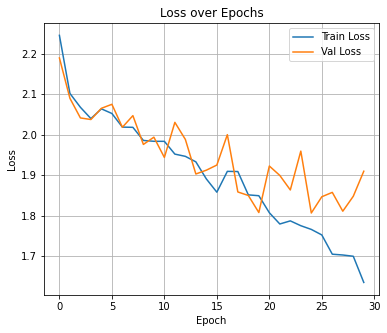

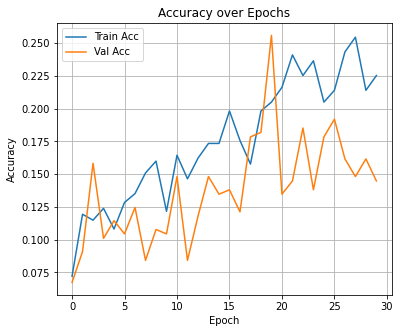

In [45]:
#Loss over epochs
plt.figure(figsize=(6, 5))
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(val_loss_hist, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend(); plt.grid(True)
plt.show()

#Accuracy over epochs
plt.figure(figsize=(6, 5))
plt.plot(train_acc_hist, label='Train Acc')
plt.plot(val_acc_hist, label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend(); plt.grid(True)
plt.show()

Doing Downsampling increased it by 1% 